<a href="https://colab.research.google.com/github/rizalagussaini/penguin_clustering_code/blob/main/penguin_clustering_code_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Info data awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


<ipython-input-1-0327f18708d8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sex'] = le.fit_transform(df_clean['sex'])
<ipython-input-1-0327f18708d8>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['culmen_ratio'] = df_clean['culmen_length_mm'] / df_clean['culmen_depth_mm']


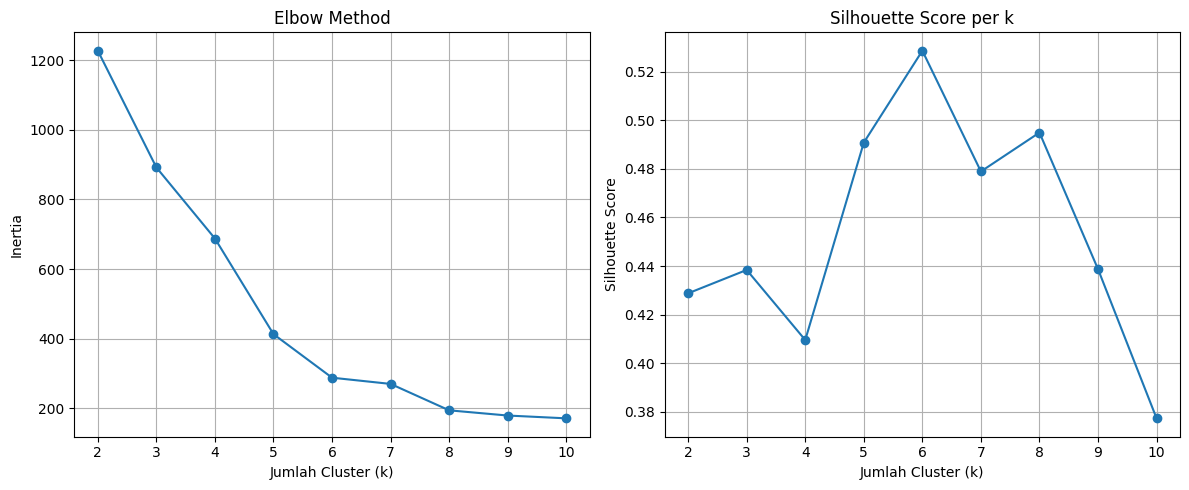

Jumlah cluster optimal berdasarkan Silhouette Score: 6
Silhouette Score KMeans (k=6): 0.529
Davies-Bouldin Index KMeans (k=6): 0.577


<ipython-input-1-0327f18708d8>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cluster'] = labels


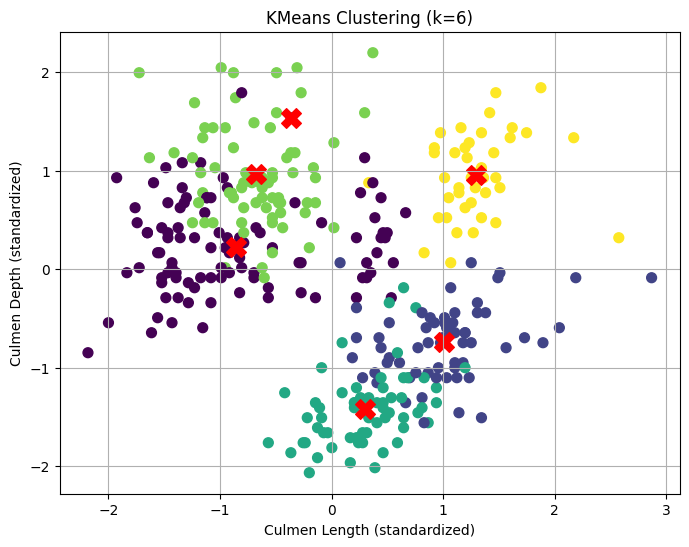

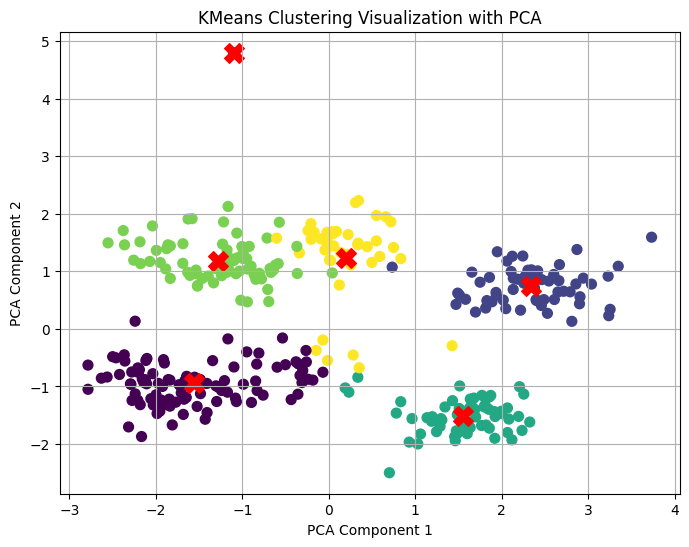

DBSCAN - jumlah cluster (tidak termasuk noise): 2
DBSCAN - jumlah noise: 4
DBSCAN Silhouette Score (non-noise): 0.317
Agglomerative Clustering Silhouette Score: 0.521
Hasil clustering disimpan ke 'penguins_with_clusters.csv'


In [ ]:
# Install library jika belum ada
!pip install pandas matplotlib scikit-learn seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv('penguins.csv')

# Info data awal
print("Info data awal:")
df.info()

# Hapus baris dengan missing values
df_clean = df.dropna()

# Encode kolom gender
le = LabelEncoder()
df_clean['sex'] = le.fit_transform(df_clean['sex'])

# Buat fitur baru: culmen_ratio
df_clean['culmen_ratio'] = df_clean['culmen_length_mm'] / df_clean['culmen_depth_mm']

# Pilih fitur untuk clustering
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'culmen_ratio']
X = df_clean[features]

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tentukan jumlah cluster optimal dengan Elbow dan Silhouette Score
inertia = []
silhouette_scores = []
k_range = range(2, 11)  # mulai dari 2 cluster karena 1 cluster tidak bermakna

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

# Plot Elbow
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.grid(True)

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score per k')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Pilih jumlah cluster terbaik berdasarkan plot (misal k terbaik adalah k dengan silhouette tertinggi)
k_optimal = k_range[np.argmax(silhouette_scores)]
print(f"Jumlah cluster optimal berdasarkan Silhouette Score: {k_optimal}")

# Clustering dengan KMeans k optimal
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

df_clean['cluster'] = labels

# Evaluasi clustering
sil_score = silhouette_score(X_scaled, labels)
dbi_score = davies_bouldin_score(X_scaled, labels)
print(f"Silhouette Score KMeans (k={k_optimal}): {sil_score:.3f}")
print(f"Davies-Bouldin Index KMeans (k={k_optimal}): {dbi_score:.3f}")

if 'species' in df_clean.columns:
    df_clean['species_encoded'] = LabelEncoder().fit_transform(df_clean['species'])
    ari_score = adjusted_rand_score(df_clean['species_encoded'], labels)
    print(f"Adjusted Rand Index (ARI): {ari_score:.3f}")

# Visualisasi KMeans dengan dua fitur utama
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X')
plt.title(f'KMeans Clustering (k={k_optimal})')
plt.xlabel('Culmen Length (standardized)')
plt.ylabel('Culmen Depth (standardized)')
plt.grid(True)
plt.show()

# Visualisasi PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(pca.transform(centroids)[:, 0], pca.transform(centroids)[:, 1], c='red', s=200, marker='X')
plt.title('KMeans Clustering Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# Bandingkan dengan DBSCAN dan Agglomerative Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_dbscan_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN - jumlah cluster (tidak termasuk noise): {n_dbscan_clusters}")
print(f"DBSCAN - jumlah noise: {n_dbscan_noise}")

if n_dbscan_clusters > 1:
    dbscan_sil = silhouette_score(X_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"DBSCAN Silhouette Score (non-noise): {dbscan_sil:.3f}")

agglo = AgglomerativeClustering(n_clusters=k_optimal)
agglo_labels = agglo.fit_predict(X_scaled)
agglo_sil = silhouette_score(X_scaled, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglo_sil:.3f}")

# Simpan hasil cluster ke CSV
df_clean.to_csv('penguins_with_clusters.csv', index=False)
print("Hasil clustering disimpan ke 'penguins_with_clusters.csv'")


# Analisis


**1. Data dan Persiapan**

Dataset awal terdiri dari 344 data penguin dengan 5 kolom: panjang paruh (culmen length), kedalaman paruh (culmen depth), panjang sirip (flipper length), berat tubuh (body mass), dan jenis kelamin (sex).

Data dibersihkan dengan menghapus baris yang ada nilai kosong.

Kolom jenis kelamin diubah menjadi angka supaya bisa dipakai untuk clustering.

Ditambahkan fitur baru yaitu rasio panjang paruh terhadap kedalaman paruh untuk memperkaya informasi fisik penguin.

**2. Jumlah Cluster dan Evaluasi**

Metode Elbow dan Silhouette Score menunjukkan jumlah cluster optimal adalah 6.

Clustering dengan KMeans menggunakan 6 cluster menghasilkan:

Silhouette Score = 0.529, yang artinya cluster yang terbentuk cukup baik dan data dalam cluster relatif homogen.

Davies-Bouldin Index = 0.577, nilai yang cukup rendah menandakan cluster yang terbentuk cukup terpisah dengan baik.


**Algoritma lain:**

DBSCAN menghasilkan 2 cluster plus 4 data noise, dengan Silhouette Score lebih rendah (0.317), menandakan cluster kurang rapat dan ada banyak data yang tidak masuk cluster.

Agglomerative Clustering juga menghasilkan hasil yang mirip dengan KMeans (jumlah cluster 6), dengan Silhouette Score 0.521, cukup baik.


**3. Kesesuaian Cluster dengan Spesies Penguin**

Jika ada label spesies asli (misal: Adelie, Gentoo, Chinstrap), kamu bisa mengukur Adjusted Rand Index (ARI) untuk melihat seberapa baik hasil cluster sesuai dengan spesies nyata.

ARI mendekati 1 berarti cluster sangat sesuai dengan spesies asli, mendekati 0 berarti hasil cluster tidak sesuai.

Data ini belum terlihat hasil ARI-nya, tapi biasanya fitur fisik yang dipakai cukup representatif untuk membedakan spesies utama penguin.


**4. Interpretasi Hasil**

Dengan 6 cluster, model membagi penguin menjadi kelompok-kelompok berdasarkan karakteristik fisik seperti ukuran paruh, sirip, berat tubuh, dan jenis kelamin.

Cluster ini bisa jadi membedakan subkelompok dalam spesies atau variasi alami dalam populasi penguin.

Nilai evaluasi yang baik menandakan pemisahan cluster cukup jelas dan data dalam cluster saling mirip.


**5. Saran untuk Pengembangan**

Cek hasil cluster terhadap label spesies asli jika ada, untuk validasi lebih akurat.

Eksplorasi fitur tambahan atau teknik reduksi dimensi lain (t-SNE, UMAP).

Eksperimen parameter DBSCAN agar bisa mengenali cluster berbentuk tidak bulat dan noise dengan lebih baik.


**Kesimpulan singkat:**

Clustering KMeans dengan 6 cluster memberikan hasil yang cukup baik dalam mengelompokkan penguin berdasarkan fitur fisik utama. Ini bisa membantu memahami variasi dan kemungkinan subspesies atau kelompok alami di populasi penguin yang diteliti.







